In [1]:
%matplotlib inline
import collections
import sys
import subprocess
import pandas as pd
import os
import numpy as np
import uuid
import tempfile
import bnpy
import scikit_posthocs as sp
import itertools
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import kruskal, f_oneway
from scipy.stats import ttest_ind

sys.path.append('/opt/hydra/')

src = os.environ["HYDRA_SRC"]

import library.analysis as hy
import library.fit as ft

In [2]:
mm_genes = '../data/TH-OSTEO-MINUS-TARGET/MultiModalGenes/'
exp_path = '../data/TH-OSTEO-MINUS-TARGET.tsv'

In [3]:
exp = pd.read_csv(exp_path, sep='\t', index_col=0)

In [4]:
exp.shape

(15528, 106)

In [4]:
if False:

    scan = hy.ScanEnrichmentAnalysis(mm_genes, 
                                     exp_path, 
                                     'GO', 
                                     min_prob_range=np.linspace(0.1, 0.3, 25), 
                                     CPU=7,
                                     K=5).scan()
    
    scan

In [5]:
res = hy.EnrichmentAnalysis(exp_path=exp_path,
                            mm_path=mm_genes,
                            min_prob_filter=0.266667,
                            gmt_path='GO')

In [6]:
res.get_enriched_terms()

,Unnamed: 0,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
0,GO:0006958,GO:0006958,"complement activation, classical pathway",24/295,74/11850,7.231908e-21,2.088575e-17,1.959467e-17,IGHV3-15/IGHG3/IGKV1D-39/IGKV3-15/IGHV3-7/IGLV...,24
1,GO:0006171,GO:0006171,cAMP biosynthetic process,8/295,63/11850,1.582080e-04,1.044109e-02,9.795658e-03,LTB4R2/NPR3/UCN2/GIPR/MARCO/ADCY2/PTHLH/EDN1,8


In [7]:
genes = res.get_enriched_term_genes()

len(genes)

32

In [8]:
clus = hy.MultivariateMixtureModel(data=exp.reindex(genes),
                                   center=True,
                                   gamma=5.0,
                                   variance=2.0,
                                   K=5, 
                                   verbose=True)

centering data


In [9]:
exp.reindex(clus.clusters[0], axis=1).to_csv('../data/TREE-osteo-Cluster-0.tsv', sep='\t')

In [10]:
assignments = clus.get_assignments(exp.reindex(genes))

assign = pd.DataFrame(index=exp.columns,
                      columns=[1])

for sample, assignment in zip(exp.columns, assignments):
    assign.loc[sample, 1] = assignment + 1

In [11]:
hclust = hy.HClust(data=exp.reindex(genes))

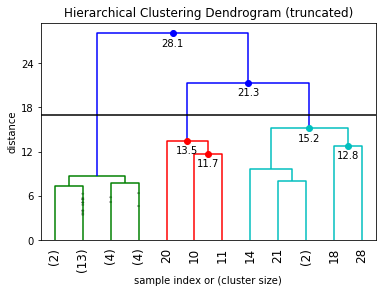

In [12]:
hclust.plot_row_linkage(17)
row_groups = hclust.get_row_groups(17)

In [13]:
sns.color_palette("Set2", max(assign[1].values))

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

In [14]:
assign.sort_values(1)[1].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

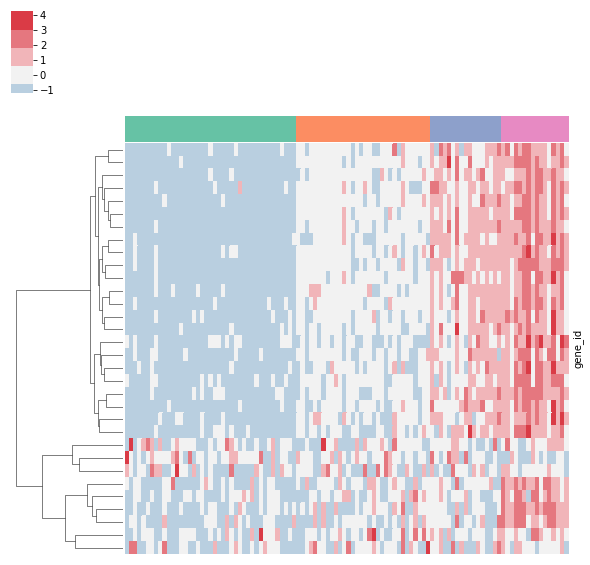

In [15]:
col_order = assign.sort_values(1).index.values
cmap = sns.color_palette("Set2", max(assign[1].values))
col_colors = [cmap[x - 1] for x in assign.sort_values(1)[1].values]

g = sns.clustermap(exp.reindex(genes).reindex(col_order, axis=1),
                   col_cluster=False,
                   col_colors=col_colors,
                   z_score=0,
                   method='ward',
                   center=0,
                   cmap=sns.diverging_palette(240, 10, n=7),
                   figsize=(10, 10))

ax = g.ax_heatmap

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

pth = '../img/expression-heatmap.svg'
plt.savefig(pth, format='svg', bbox_inches='tight')

pth = '../img/expression-heatmap.png'
plt.savefig(pth, format='png', bbox_inches='tight')

In [16]:
fgsea = clus.get_cluster_features(exp, 
                                  gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')

In [ ]:
fgsea[]

In [17]:
def format_pathway(x):
    fields = x.split('%')
    return '%s (%s)' % (fields[0], fields[1])

pth = '../img/TREE-top-10-pathways-cluster-%d.tex'
for key, values in fgsea.items():
    with pd.option_context('display.precision', 2):
        t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
        t['pathway'] = t['pathway'].apply(format_pathway)
        with open(pth % key, 'w') as f:
            print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(index=False))
            t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10).to_latex(f, index=False)

\begin{tabular}{lrr}
\toprule
                                           pathway &      padj &   NES \\
\midrule
                            TRANSLATION (REACTOME) &  1.56e-03 &  4.14 \\
 CHROMOSOME MAINTENANCE (REACTOME DATABASE ID R... &  1.52e-03 &  3.95 \\
     MITOCHONDRIAL TRANSLATIONAL ELONGATION (GOBP) &  1.52e-03 &  3.84 \\
                  HALLMARK\_E2F\_TARGETS (MSIGDB\_C2) &  1.52e-03 &  3.84 \\
                                TRANSLATION (GOBP) &  1.57e-03 &  3.83 \\
 MITOCHONDRIAL TRANSLATION ELONGATION (REACTOME... &  1.52e-03 &  3.82 \\
               HALLMARK\_MYC\_TARGETS\_V1 (MSIGDB\_C2) &  1.52e-03 &  3.80 \\
 DEPOSITION OF NEW CENPA-CONTAINING NUCLEOSOMES... &  1.52e-03 &  3.78 \\
                    NUCLEOSOME ASSEMBLY (REACTOME) &  1.52e-03 &  3.78 \\
 MITOCHONDRIAL TRANSLATION TERMINATION (REACTOM... &  1.52e-03 &  3.75 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
                                           pathway &  padj &   NES \\
\midrule
    

In [18]:
fgsea_df = None
for key, values in fgsea.items():
    if fgsea_df is None:
        header = pd.MultiIndex.from_product([list(fgsea.keys()), 
                                             ['padj', 'NES']],
                                           names=['cluster', 'feature'])
        
        fgsea_df = pd.DataFrame(index=values.index.values, columns=header)
        
    print 'Key: ', key,
    t = values.reset_index().reindex(['pathway', 'padj', 'NES'], axis=1)
    t['pathway'] = t['pathway'].apply(format_pathway) 
    print(t[(t['NES'] > 0) & (t['padj'] < 0.05)].sort_values('NES', ascending=False).head(10))
    
    fgsea_df[(key, 'padj')] = values.loc[fgsea_df.index, 'padj'].values
    fgsea_df[(key, 'NES')] = values.loc[fgsea_df.index, 'NES'].values

Key:  0                                              pathway      padj       NES
0                             TRANSLATION (REACTOME)  0.001560  4.139629
1  CHROMOSOME MAINTENANCE (REACTOME DATABASE ID R...  0.001524  3.950873
2      MITOCHONDRIAL TRANSLATIONAL ELONGATION (GOBP)  0.001524  3.835701
3                   HALLMARK_E2F_TARGETS (MSIGDB_C2)  0.001524  3.835053
4                                 TRANSLATION (GOBP)  0.001575  3.825652
5  MITOCHONDRIAL TRANSLATION ELONGATION (REACTOME...  0.001524  3.816204
6                HALLMARK_MYC_TARGETS_V1 (MSIGDB_C2)  0.001524  3.798189
7  DEPOSITION OF NEW CENPA-CONTAINING NUCLEOSOMES...  0.001524  3.776446
8                     NUCLEOSOME ASSEMBLY (REACTOME)  0.001524  3.776446
9  MITOCHONDRIAL TRANSLATION TERMINATION (REACTOM...  0.001524  3.753843
Key:  1                                              pathway      padj       NES
0           EXTRACELLULAR MATRIX ORGANIZATION (GOBP)  0.035369  4.378062
1        EXTRACELLULAR STRUCTURE OR

In [19]:
pth = '../data/TH-Osteo-Pathways-Enrichment.tsv'
fgsea_df.to_csv(pth, sep='\t')

In [19]:
if False:
    for sample in exp.columns:
        r = clus.sub_cluster_gsea(exp[sample],
                                  gmt='/opt/hydra/gene-sets/Human_GOBP_AllPathways_no_GO_iea_December_01_2018_symbol.gmt')
    
        sigs = r[1][(r[1]['ES'] > 0) & (r[1]['padj'] < 0.05) & (r[1]['size'] > 1)].sort_values('padj')
    
        if len(sigs) > 0:
            print(sample, r[0])
            print(sigs)

In [20]:
# Use Treehouse model to cluster TARGET osteosarcoma

pth = '../data/TARGET-OSTEO-V10.tsv'
test = pd.read_csv(pth, sep='\t', index_col=0)

In [21]:
test.head()

,TARGET-40-0A4HMC-01A-01R,TARGET-40-0A4HX8-01A-01R,TARGET-40-0A4HXS-01A-01R,TARGET-40-0A4HY5-01A-01R,TARGET-40-0A4I0Q-01A-01R,TARGET-40-0A4I0W-01A-01R,TARGET-40-0A4I3S-01A-01R,TARGET-40-0A4I42-01A-01R,TARGET-40-0A4I48-01A-01R,TARGET-40-0A4I4E-01A-01R,...,TARGET-40-PATMPU-01A-01R,TARGET-40-PATMXR-01A-01R,TARGET-40-PATPBS-01A-01R,TARGET-40-PATUXZ-01A-01R,TARGET-40-PAUBIT-01A-01R,TARGET-40-PAUTWB-01A-01R,TARGET-40-PAUTYB-01A-01R,TARGET-40-PAUUML-01A-01R,TARGET-40-PAVALD-01A-01R,TARGET-40-PAVCLP-01A-01R
gene_id,,,,,,,,,,,,,,,,,,,,,
5S_rRNA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.424922,0.000000,5.324090,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
5_8S_rRNA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
7SK,0.000000,0.000000,0.000000,2.475085,0.000000,0.000000,0.000000,0.000000,0.485427,0.000000,...,0.000000,0.000000,0.565597,2.361768,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
A1BG,6.079805,4.628190,4.666757,7.344562,5.608513,4.490570,4.931683,6.519793,6.714932,6.156842,...,4.545351,3.986411,3.499527,5.993901,5.604961,6.058533,7.479861,3.346248,6.19869,6.994127
A1BG-AS1,2.107688,3.279471,1.632268,3.424922,1.361768,2.204767,3.289834,2.217231,3.866908,2.533563,...,2.627607,1.794936,1.310340,3.371559,3.468583,2.344829,2.829849,1.137504,2.24184,2.869871


In [22]:
exp.reindex(genes).sub(exp.reindex(genes).mean(axis=1), axis=0).mean(axis=1).sum()

-7.446873306683835e-16

In [23]:
test.reindex(genes).sub(exp.reindex(genes).mean(axis=1), axis=0)

,TARGET-40-0A4HMC-01A-01R,TARGET-40-0A4HX8-01A-01R,TARGET-40-0A4HXS-01A-01R,TARGET-40-0A4HY5-01A-01R,TARGET-40-0A4I0Q-01A-01R,TARGET-40-0A4I0W-01A-01R,TARGET-40-0A4I3S-01A-01R,TARGET-40-0A4I42-01A-01R,TARGET-40-0A4I48-01A-01R,TARGET-40-0A4I4E-01A-01R,...,TARGET-40-PATMPU-01A-01R,TARGET-40-PATMXR-01A-01R,TARGET-40-PATPBS-01A-01R,TARGET-40-PATUXZ-01A-01R,TARGET-40-PAUBIT-01A-01R,TARGET-40-PAUTWB-01A-01R,TARGET-40-PAUTYB-01A-01R,TARGET-40-PAUUML-01A-01R,TARGET-40-PAVALD-01A-01R,TARGET-40-PAVCLP-01A-01R
gene_id,,,,,,,,,,,,,,,,,,,,,
IGKV4-1,-0.191302,-2.547446,0.996050,-2.547446,-2.547446,-2.547446,-2.547446,-2.547446,-1.497815,-2.547446,...,-2.547446,-2.547446,-1.470203,-2.125213,-1.933914,-2.136020,-2.308659,-2.547446,-2.547446,-0.023884
IGHV3-15,-0.799524,-1.671368,1.562827,-1.671368,-1.671368,-1.671368,-1.671368,-1.671368,-1.671368,-1.671368,...,-1.671368,-1.671368,-1.303997,-1.372709,-1.671368,-1.671368,-1.495045,-1.671368,-1.671368,-1.469734
IGKV1-16,-1.510916,-1.773951,1.224245,-1.773951,-1.773951,-1.773951,-1.773951,-1.773951,-1.535164,-1.773951,...,-1.773951,-1.773951,-0.958375,-1.773951,-1.773951,-1.773951,-1.319775,-1.773951,-1.773951,-1.773951
IGKV1-17,-0.240448,-1.710334,1.287862,-1.710334,-1.710334,-1.710334,-1.710334,-1.710334,-1.710334,-1.164365,...,-1.710334,-1.710334,1.796827,-1.710334,-1.710334,-0.405823,-1.710334,-1.710334,-1.710334,-1.710334
IGHG3,0.973812,-2.923157,1.338191,-3.020768,-2.992198,-2.896440,-2.733887,-3.020768,-0.609341,-1.342696,...,-2.978123,-2.733887,-1.831734,-2.587808,-2.710428,-0.002846,-2.027999,-2.819134,-3.020768,0.071778
IGKV1D-39,0.094562,-2.300069,1.688744,-3.131946,-3.131946,-3.131946,-3.131946,-3.131946,-0.549390,-3.131946,...,-3.131946,-3.131946,-1.481182,-1.626055,-1.833288,-2.324591,-2.677770,-2.183345,-3.131946,-0.704340
IGLV2-11,0.714879,-2.283317,-0.050656,-1.904805,-2.283317,-2.283317,-1.698354,-2.283317,-2.283317,-2.283317,...,-2.283317,-2.283317,-1.861083,-2.283317,-1.893750,-1.327260,-2.283317,-2.283317,-2.283317,-1.818648
IGHV3-33,-0.120690,-1.952567,-0.477482,-1.952567,-1.952567,-1.952567,-1.952567,-1.952567,-1.301803,-1.212719,...,-1.689533,-1.952567,-0.508961,-1.619143,-1.952567,-1.348496,-1.952567,-1.952567,-1.952567,-0.875324
IGLV6-57,-1.099928,-1.350890,-1.028962,-1.350890,-1.350890,-1.350890,-1.350890,-1.350890,-0.961323,-1.350890,...,-1.350890,-1.350890,-1.200330,-0.387416,-1.350890,-1.350890,-1.075883,-1.350890,-1.350890,-0.785293


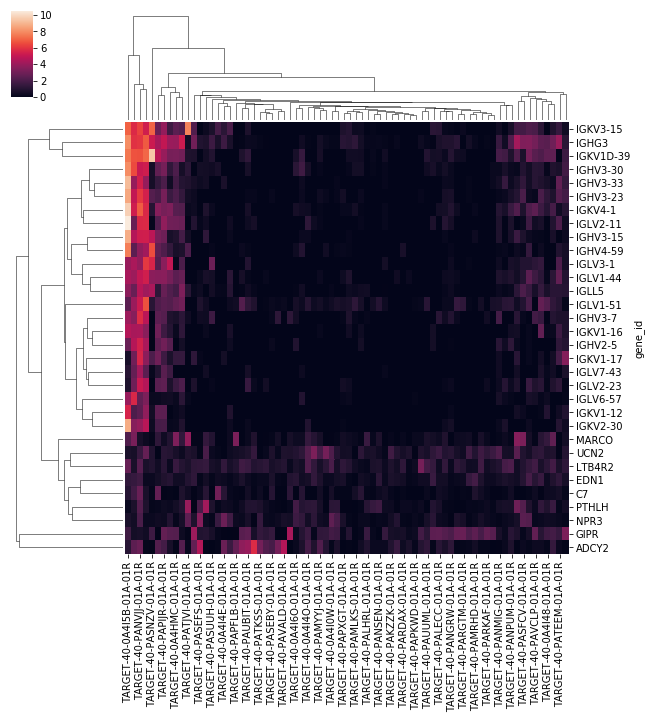

In [24]:
sns.clustermap(test.reindex(genes))

In [25]:
help(clus.get_assignments)

Help on method get_assignments in module library.analysis:

get_assignments(self, data) method of library.analysis.MultivariateMixtureModel instance



In [26]:
import collections

test_assign = pd.DataFrame(index=test.columns, columns=['cluster'])

for sample, cluster in zip(test.columns, clus.get_assignments(test)):
    test_assign.loc[sample, 'cluster'] = cluster

In [27]:
assign

,1
TH27_1159_S01,2
TH27_1169_S01,1
TH06_1172_S01,1
TH27_1267_S01,2
TH27_1271_S01,2
TH27_1273_S01,3
TH34_1351_S01,4
TH27_1357_S01,1
TH03_0139_S01,1
TH03_0140_S01,3


In [28]:
treec0 = assign[assign[1] == 1]
treec0

,1
TH27_1169_S01,1
TH06_1172_S01,1
TH27_1357_S01,1
TH03_0139_S01,1
TH03_0160_S01,1
THR24_2088_S01,1
THR24_2090_S01,1
THR24_2091_S01,1
THR24_2092_S01,1
THR24_2093_S01,1


In [29]:
treec0 = assign[assign[1] == 1].index.values
testc0 = test_assign[test_assign['cluster'] == 0].index.values

merged = pd.concat([exp.reindex(treec0, axis=1), test.reindex(testc0, axis=1)], axis=1, join='inner')
merged.to_csv('../data/TREE-TARGET-C0-MERGED.tsv', sep='\t')

In [30]:
test_assign

,cluster
TARGET-40-0A4HMC-01A-01R,1
TARGET-40-0A4HX8-01A-01R,0
TARGET-40-0A4HXS-01A-01R,1
TARGET-40-0A4HY5-01A-01R,0
TARGET-40-0A4I0Q-01A-01R,0
TARGET-40-0A4I0W-01A-01R,0
TARGET-40-0A4I3S-01A-01R,0
TARGET-40-0A4I42-01A-01R,0
TARGET-40-0A4I48-01A-01R,1
TARGET-40-0A4I4E-01A-01R,0


In [31]:
def get_event(event):
    if pd.isnull(event):
        print("NULL")
        return np.nan
    
    events = ['Relapse',
              'Death', 
              'Progression',
              'Event',
              'Second Malignant Neoplasm',
              'SMN']
    
    if event in ['Censored', 'No event', 'None']:
        return 0
    
    elif event in events:
        return 1 
    
    else:
        raise ValueError(event)
        
def get_vital(vital):
    if pd.isnull(vital):
        #print("NULL")
        return np.nan
    
    
    if vital == 'Alive':
        return 0
    
    elif vital == 'Dead':
        return 1
    
    else:
        raise ValueError(vital)

pth = '../../without-muscle/data/TARGET_OS_ClinicalData_Discovery_20181009.xlsx'
clinical = pd.read_excel(pth, index_col=0)

surv = pd.DataFrame(index=test.columns, 
                    columns=['OS', 'vital', 'EFS', 'event'])

for sample in test.columns:
    root = '-'.join(sample.split('-')[:3])
    if root not in clinical.index:
        print "Missing: ", sample
        continue
    
    OS = clinical.loc[root, 'Overall Survival Time in Days'].item()
    vital = get_vital(clinical.loc[root, 'Vital Status'])
    
    EFS = clinical.loc[root, 'Event Free Survival Time in Days'].item()
    #print(repr(clinical.loc[root, 'First Event']))
    event = get_event(clinical.loc[root, 'First Event'])
    
    surv.loc[sample, :] = [OS, vital, EFS, event]
    

for sample in test.columns:
    surv.loc[sample, 'cluster'] = int(test_assign.loc[sample, 'cluster'])
    
#surv = surv[surv['cluster'].isin([2.0, 3.0])]

surv = surv.dropna()
    
surv.to_csv('../data/TARGET-osteo-TH-assignment-survival.tsv', sep='\t')

surv

NULL
NULL
NULL


,OS,vital,EFS,event,cluster
TARGET-40-0A4HMC-01A-01R,377,0,377,0,1.0
TARGET-40-0A4HX8-01A-01R,1750,0,3050,0,0.0
TARGET-40-0A4HXS-01A-01R,2948,0,2948,0,1.0
TARGET-40-0A4HY5-01A-01R,290,1,218,1,0.0
TARGET-40-0A4I0Q-01A-01R,519,1,519,1,0.0
TARGET-40-0A4I0W-01A-01R,683,0,683,0,0.0
TARGET-40-0A4I3S-01A-01R,1844,0,1844,0,0.0
TARGET-40-0A4I42-01A-01R,619,1,351,1,0.0
TARGET-40-0A4I48-01A-01R,1616,0,1616,0,1.0
TARGET-40-0A4I4M-01A-01R,708,0,708,0,1.0


In [32]:
# This doesn't work for osteo
if False:
    for sample in test.columns:
        r = clus.sub_cluster_gsea(test[sample],
                                  gmt='/opt/hydra/data/Human_GO_AllPathways_no_GO_iea_October_01_2018_symbol.gmt')
    
        sigs = r[1][(r[1]['ES'] > 0) & (r[1]['padj'] < 0.05) & (r[1]['size'] > 1)].sort_values('padj')
    
        if len(sigs) > 0:
            print(sample, r[0])
            print(sigs)